In [2]:

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from transformers import pipeline
from PIL import Image
import pandas as pd

from jhu_handler import JHU_handler

DB = JHU_handler()

/home/gaetan/projects/image-depth-estimation/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Head detection

In [3]:
photo_id = 1857 # 1857,1555, 1691, 2184, 4088

In [4]:
from ultralytics import YOLO
import cv2
import numpy as np

# Load the model
model = YOLO('models-checkpoints/bestyolo11l.pt')  # load the custom model from checkpoint

# Function to run inference on an image

# random image
image_path, heads, info = DB.get_image("2256")
# image_path, heads, info = DB.get_random_image()
print(f"image {info['filename']} with {info['total-count']} heads")

# print(heads)
results = model(image_path)
detected_heads = pd.DataFrame(columns=["x", "y", "w", "h"])
annotaded_image = results[0].plot()
# plt.imshow(annotaded_image)

for result in results:
    print("###################")
    boxes = result.boxes
    # print(boxes)
    for box in boxes:
        # print(box)
        x = box.xywh[0]
        new_row = {
            "x": float(x[0]),
            "y": float(x[1]), 
            "w": float(x[2]),
            "h": float(x[3])
        }
        # Ajouter la ligne au DataFrame
        detected_heads.loc[len(detected_heads)] = new_row


print(f"RESULT: {len(detected_heads)} / {len(heads)} heads detected")


image 2256 with 325 heads

image 1/1 /mnt/c/Users/gaeta/OneDrive - CentraleSupelec/3A/Safeband/Projet - InfoNum/Datasets/BigDSimages/jhu_crowd_v2.0/jhu_crowd_v2.0/train/images/2256.jpg: 320x544 92 heads, 427.4ms
Speed: 2.9ms preprocess, 427.4ms inference, 6.0ms postprocess per image at shape (1, 3, 320, 544)
###################
RESULT: 92 / 325 heads detected


image size: (1000, 562)


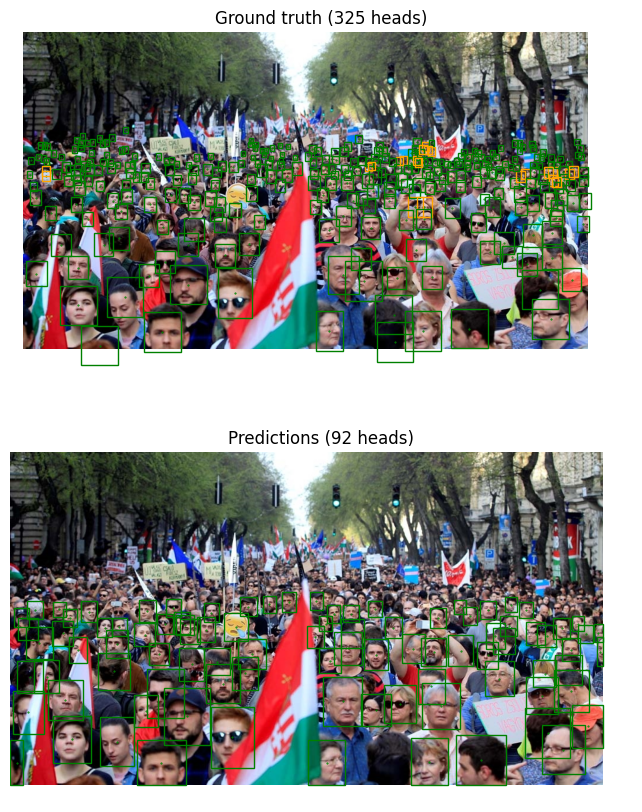

In [5]:
# show results
fig, axes = plt.subplots(2,1, figsize=(10,10)) 
image = Image.open(image_path)
print("image size:", image.size)
DB.show_img(image, ax=axes[0])
DB.show_img(image, ax=axes[1])
DB.show_headboxes(heads, ax=axes[0])
DB.show_headboxes(detected_heads, ax=axes[1])
axes[0].set_title(f"Ground truth ({info['total-count']} heads)")
axes[1].set_title(f"Predictions ({len(detected_heads)} heads)")
axes[0].set_axis_off()
axes[1].set_axis_off()


## depth estimation

In [6]:
pipe = pipeline(task="depth-estimation", model="depth-anything/Depth-Anything-V2-Metric-Outdoor-base-hf")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu


In [7]:

# 1555, 
img = Image.open(image_path)
print(f"image {info['filename']} with {info['total-count']} heads")
print("image size:", img.size)  
result = pipe(img)
depth = result["predicted_depth"]
print("depth shape",depth.shape)

image 2256 with 325 heads
image size: (1000, 562)
depth shape torch.Size([562, 1000])


/tmp/ipykernel_137989/727734977.py:11: UserWarning: Adding colorbar to a different Figure <Figure size 640x480 with 2 Axes> than <Figure size 1000x1000 with 2 Axes> which fig.colorbar is called on.
  fig.colorbar(im2, ax=ax, fraction=0.03, pad=0.04)
/tmp/ipykernel_137989/727734977.py:18: UserWarning: Adding colorbar to a different Figure <Figure size 640x480 with 2 Axes> than <Figure size 1000x1000 with 2 Axes> which fig.colorbar is called on.
  fig.colorbar(im2, ax=ax, fraction=0.03, pad=0.04)


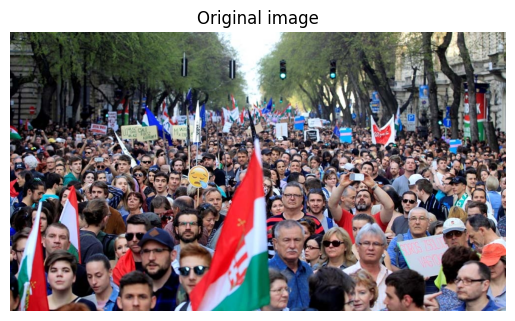

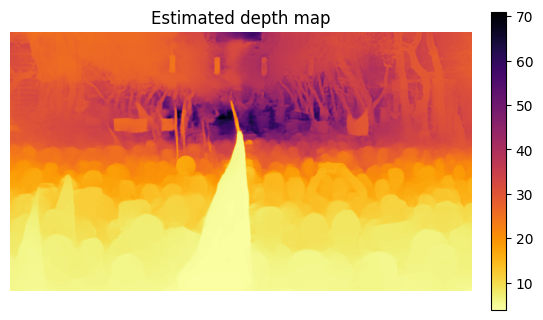

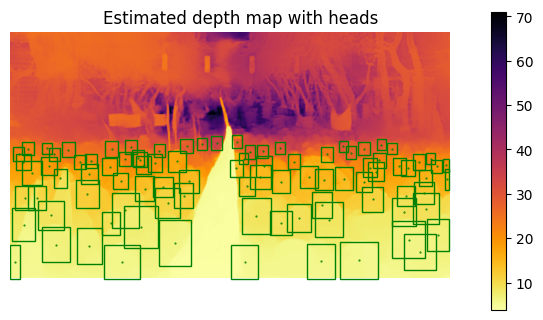

In [8]:
# show result
figure = plt.figure()
ax = figure.subplots()
DB.show_img(img,ax=ax)
ax.set_title(f"Original image")
ax.set_axis_off()
# DB.show_headboxes(heads, ax=axes[0])
figure = plt.figure()
ax = figure.subplots()
im2 = ax.imshow(depth, cmap='inferno_r' )
fig.colorbar(im2, ax=ax, fraction=0.03, pad=0.04)
ax.set_title(f"Estimated depth map")
ax.set_axis_off()

figure = plt.figure()
ax = figure.subplots()
im2 = ax.imshow(depth, cmap='inferno_r' )
fig.colorbar(im2, ax=ax, fraction=0.03, pad=0.04)
DB.show_headboxes(detected_heads, ax=ax)
ax.set_title(f"Estimated depth map with heads")
ax.set_axis_off()



In [9]:
# angle estimation: 

# height according to the depth map

# img.size, depth.size
# heights = []
# depths = []
# for h in range(0, depth.shape[0]):
#     # for w in range(0, depth.size[0], 10):
#     depths.append(max([ depth[h, w] for w in range(0, depth.shape[1], 5)]))
#     heights.append(depth.shape[0]-h)
        
# plt.scatter(heights, depths)
# plt.xlabel("height")
# plt.ylabel("depth")
# for h in range(0)


## DISTANCE PREDICTION

### depth map linear corection

On tente de corriger la profondeur par régression linéaire en s'appuyant sur la taille des têtes détectées.
En effet, la mensurations des têtes est plutôt constant et a une faible variance, ce qui permet de l'utiliser comme variable explicative pour la profondeur.

or le produit $\text{taille tête} \times \text{profondeur}$ est proportionnel à la taille de la tête, on détermine donc une correction sous forme de régression pour redresser la distribution de ce produit par rapport à la profondeur.

Ceci nous permet théoriquement de corriger pas mal



Text(0.5, 1.0, 'after correction')

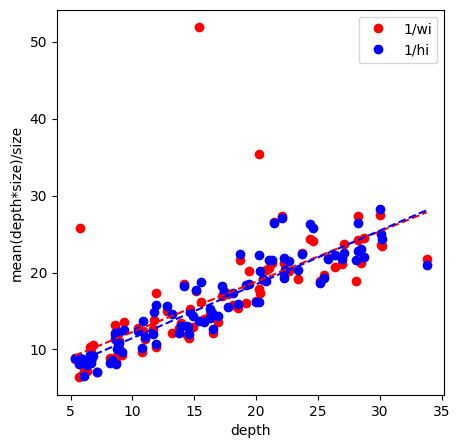

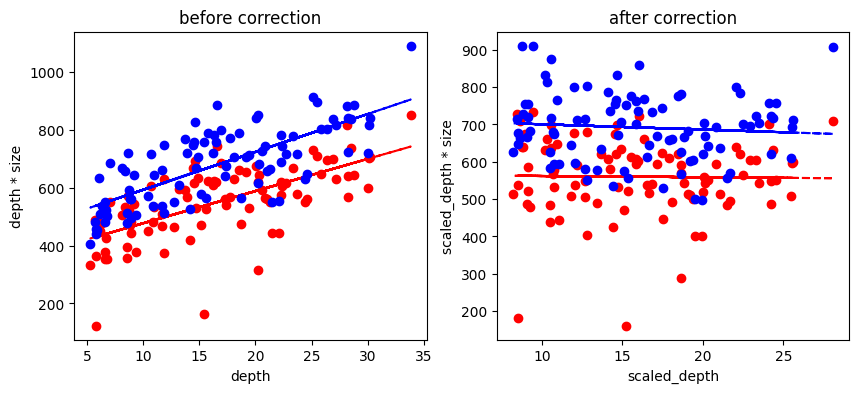

In [10]:

import scipy.optimize as opt

for i in range(len(detected_heads)):
    detected_heads.loc[i, 'depth'] = float(depth[int(detected_heads.loc[i, 'y']), int(detected_heads.loc[i, 'x'])])

obj_w = (detected_heads["w"]*detected_heads["depth"]).mean()
obj_h = (detected_heads["h"]*detected_heads["depth"]).mean()

scale = lambda x,a,b: a*x + b


popt_w, _ = opt.curve_fit(scale, detected_heads["depth"], detected_heads["w"].apply(lambda x : obj_w/x))
popt_h, _ = opt.curve_fit(scale, detected_heads["depth"], detected_heads["h"].apply(lambda x : obj_h/x))

detected_heads["depth_scaled"] = detected_heads["depth"].apply(lambda x : scale(x,*popt_h))

# figure 1
figure = plt.figure(figsize=(5,5))
plt.plot(detected_heads["depth"], obj_w/detected_heads["w"], 'ro', label="1/wi")
plt.plot(detected_heads["depth"], obj_h/detected_heads["h"], 'bo', label="1/hi")
X = np.linspace(detected_heads["depth"].min(), detected_heads["depth"].max(), 100)
plt.plot(X, scale(X, *popt_w), 'r--')
plt.plot(X, scale(X, *popt_h), 'b--')
plt.xlabel("depth")
plt.ylabel("mean(depth*size)/size")
plt.legend()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

def plot_depth_times_size(ax, depth, size, color, label):
    ax.plot(depth, depth*size,'o', color=color, label=label)
    popt,_ = opt.curve_fit(scale, depth, depth*size)
    ax.plot(depth, scale(depth,*popt), '--'+color)
    return popt

plot_depth_times_size(axes[0], detected_heads["depth"], detected_heads["w"], 'r', "$w_i$")
plot_depth_times_size(axes[0], detected_heads["depth"], detected_heads["h"], 'b', "$h_i$")
axes[0].set_xlabel("depth")
axes[0].set_ylabel("depth * size")
axes[0].set_title("before correction")

plot_depth_times_size(axes[1], detected_heads["depth_scaled"], detected_heads["w"], 'r', "$w_i$")
plot_depth_times_size(axes[1], detected_heads["depth_scaled"], detected_heads["h"], 'b', "$h_i$")
axes[1].set_xlabel("scaled_depth")
axes[1].set_ylabel("scaled_depth * size")
axes[1].set_title("after correction")


/tmp/ipykernel_137989/1866536573.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  depth_corrected = np.array(depth)
/tmp/ipykernel_137989/1866536573.py:9: UserWarning: Adding colorbar to a different Figure <Figure size 640x480 with 2 Axes> than <Figure size 1000x400 with 2 Axes> which fig.colorbar is called on.
  fig.colorbar(im2, ax=ax, fraction=0.03, pad=0.04)


<built-in method size of Tensor object at 0x7f82afedb380>
(562, 1000)


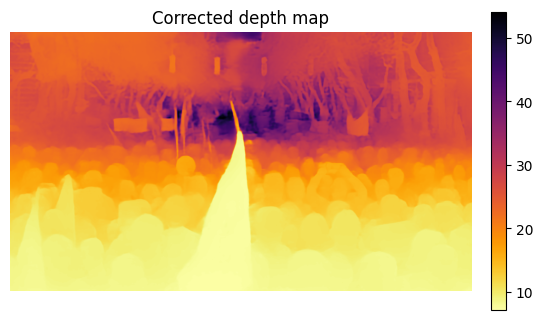

In [11]:
# results

depth_corrected = np.array(depth)
depth_corrected = scale(depth_corrected,*popt_h)

figure = plt.figure()
ax = figure.subplots()
im2 = ax.imshow(depth_corrected, cmap='inferno_r' )
fig.colorbar(im2, ax=ax, fraction=0.03, pad=0.04)
ax.set_title(f"Corrected depth map")
ax.set_axis_off()
# DB.show_headboxes(detected_heads, ax=axe)

print(depth.size)
print( depth_corrected.shape)



to estimate the distance between the points, we need to know the focal length of the objectif, we will estimate it using the size of the heads wich is statistically often the same.

### Focal length estimation

see https://www.faa.gov/sites/faa.gov/files/data_research/research/med_humanfacs/oamtechreports/AM93-10.pdf

number_of_heads 92 / 325
Optimization terminated successfully.
         Current function value: -0.000892
         Iterations: 25
         Function evaluations: 50

Estimated focal (in pixels): 3188


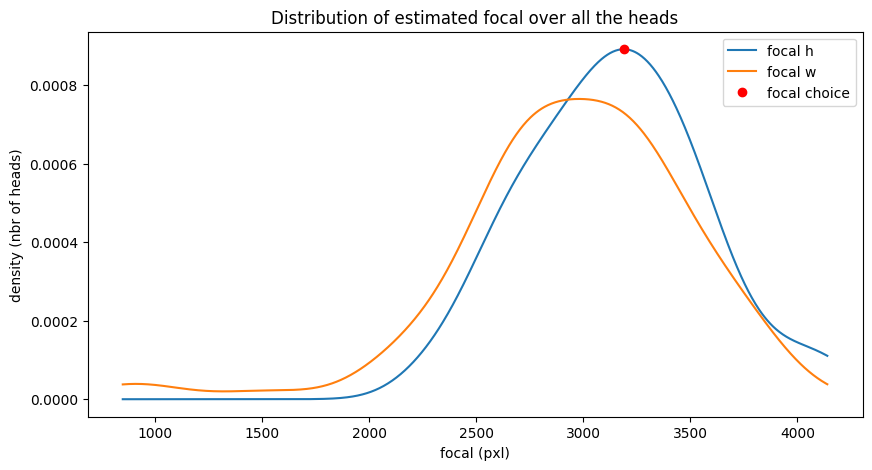

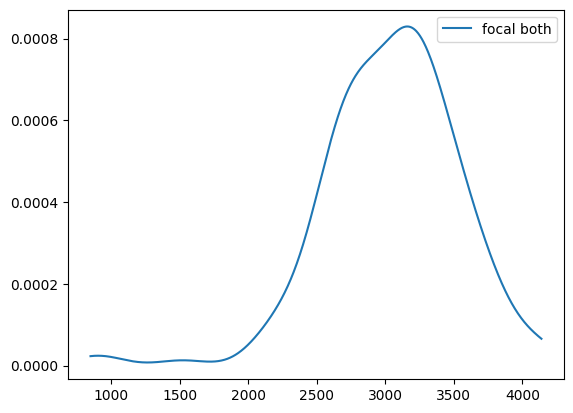

In [12]:
# good_images = 2165

import scipy.optimize as opt
import scipy.stats as stats

print("number_of_heads", len(detected_heads),"/", info['total-count'])

mean_height = 0.220 # m
mean_width = 0.190 # m


detected_heads["focal_w"] = detected_heads["depth_scaled"] * detected_heads["w"] / mean_width # largeur de tête moyenne
detected_heads["focal_h"] = detected_heads["h"] * detected_heads["depth_scaled"] / mean_height # hauteur de tête moyenne

focal_h_kde = stats.gaussian_kde(detected_heads["focal_h"])
focal_w_kde = stats.gaussian_kde(detected_heads["focal_w"])
# print(detected_heads[["focal_h","focal_w"]].to_numpy().flatten())
focal_both_kde = stats.gaussian_kde(detected_heads[["focal_h","focal_w"]].to_numpy().flatten())

xmin = detected_heads[["focal_h","focal_w"]].min(axis=None)
xmax = detected_heads[["focal_h","focal_w"]].max(axis=None)
x = np.linspace(xmin, xmax, 1000)

figure = plt.figure( figsize=(10, 5))
plt.plot(x, focal_h_kde(x), label="focal h")
plt.plot(x, focal_w_kde(x), label="focal w")
focal = int(opt.fmin(lambda x: -focal_h_kde(x), (xmin+xmax)/2)[0])
plt.plot(focal, focal_h_kde(focal), 'ro', label="focal choice")
plt.title("Distribution of estimated focal over all the heads")
plt.xlabel("focal (pxl)")
plt.ylabel("density (nbr of heads)")
plt.legend()
figure = plt.figure()
plt.plot(x, focal_both_kde(x), label="focal both")
plt.legend()

# focal estimation

print("\nEstimated focal (in pixels):", focal)


# sns.kdeplot(detected_heads["focal_w"], ax=axes2[0])
# sns.kdeplot(detected_heads["focal_h"], ax=axes2[1])

# print("focal w, mean=",detected_heads["focal_w"].mean(),", std=",detected_heads["focal_w"].std())
# print("focal h, mean=",detected_heads["focal_h"].mean(),", std=",detected_heads["focal_h"].std())



### Distance estimation

we will use the focal length to estimate the distance between the heads on the y axis

head 1 (cyan) & head 2 (blue): 45 & 37
depth 1: 20.82 m
depth 2: 10.9 m
d2-d1 = -9.92 m
blue : 225 pxl
green : 124 pxl

estimated distance in x axis at d1 (cyan) : 1.47 m
estimated distance in x axis at d2 (blue) : 0.77 m

estimated distance in x axis 1.12 m
estimated distance in y axis (green & pink)1 : 9.93 m

estimated real distance 10.04 m


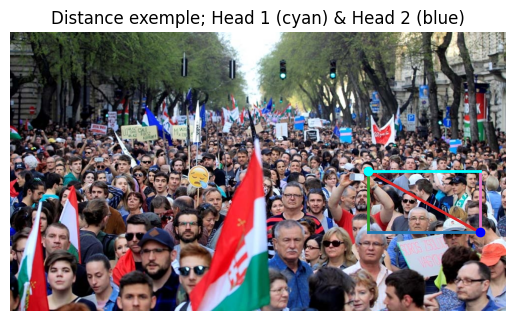

In [30]:
import random as rd
rd1 = rd.randint(0, len(detected_heads))
rd2 = rd.randint(0, len(detected_heads))
print("head 1 (cyan) & head 2 (blue):", rd1,"&",rd2)
point_1 = detected_heads.loc[61, ["x", "y","depth_scaled"]]
point_2 = detected_heads.loc[31, ["x", "y","depth_scaled"]]

x1 = point_1["x"]
y1 = point_1["y"]
x2 = point_2["x"]
y2 = point_2["y"]
d1 = point_1["depth_scaled"]
d2 = point_2["depth_scaled"]


plt.imshow(image)
plt.plot([x1, x2], [y1, y2], '-',color='tab:red',  linewidth=2)
plt.plot([x1, x1], [y1, y2], '-',color='tab:green',linewidth=2)
plt.plot([x2, x2], [y1, y2], '-',color='tab:pink',linewidth=2)
plt.plot([x1, x2], [y2, y2], '-',color='tab:blue',linewidth=2)
plt.plot([x1, x2], [y1, y1], '-',color='cyan',linewidth=2)

plt.plot(x1, y1, 'o',color = "cyan")
plt.plot(x2, y2, 'o',color='blue')
plt.axis('off')
plt.title("Distance exemple; Head 1 (cyan) & Head 2 (blue)")

print("depth 1:", round(d1,2),"m")
print("depth 2:", round(d2,2),"m")
print("d2-d1 =", round(d2-d1,2), "m")
print("blue :", round(np.abs(x2-x1)),"pxl")
print("green :", round(np.abs(y2-y1)),"pxl")
dY = np.sqrt( d1**2 + d2**2 - 2*d1*d2* ( 1 - ( np.abs(y2-y1)**2 / (2*(focal**2)) ) ) )
dx1 = (x2-x1) * d1 / focal
dx2 = (x2-x1) * d2 / focal
dX = (dx1+dx2)/2

print("")
print("estimated distance in x axis at d1 (cyan) :", round(dx1,2),"m")
print("estimated distance in x axis at d2 (blue) :", round(dx2,2),"m")
print("")
print("estimated distance in x axis", round(dX,2),"m")
print("estimated distance in y axis (green & pink)1 :", round(dY,2),"m")
print("")
print("estimated real distance", round(np.sqrt(dx1**2 + dY**2),2),"m")
